In [1]:
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
from sklearn.model_selection import train_test_split
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

In [2]:
def show_image(image,text=None, should_save=False):
    np_image = image.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()    

In [3]:
test_csv = "test_data.csv"
data_directory = "sign_data/full"

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))

    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [7]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("model.pt", map_location="cpu"))

<All keys matched successfully>

In [16]:
from dataset import Create_Dataset
test_dataset = Create_Dataset(test_csv, data_directory,
                              transform=transforms.Compose([
                                  transforms.Resize((105,105)),
                                  transforms.ToTensor()
                              ]))

test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

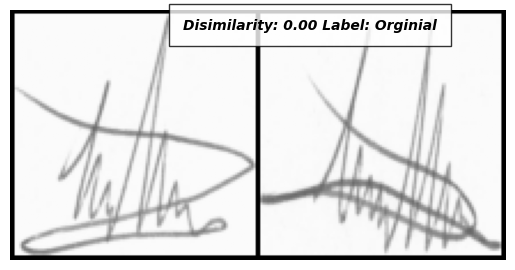

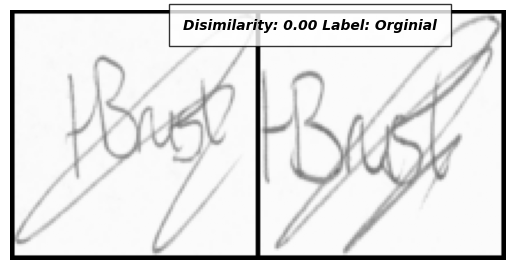

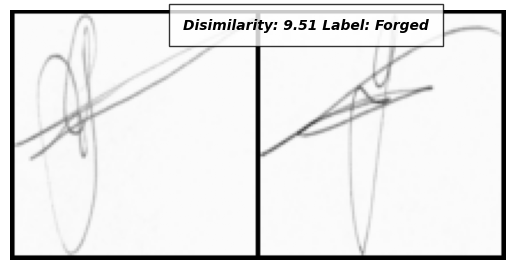

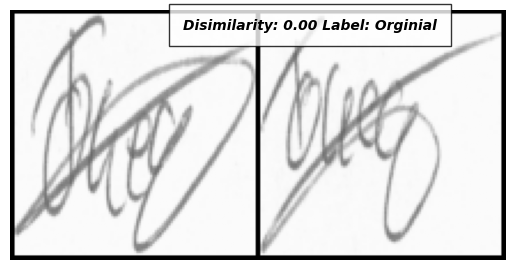

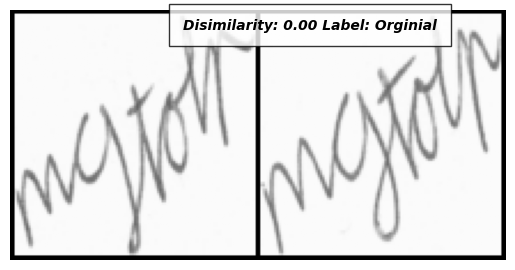

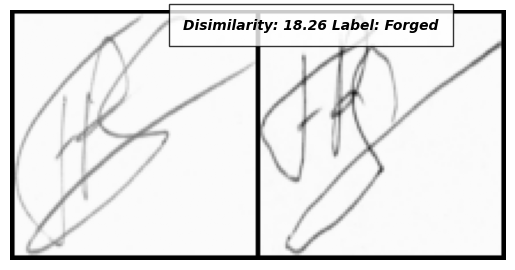

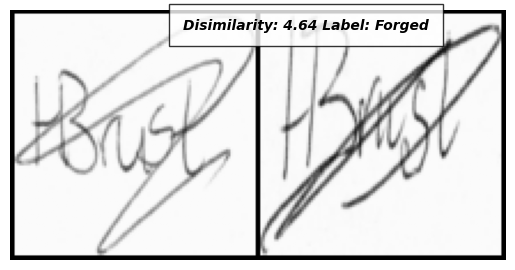

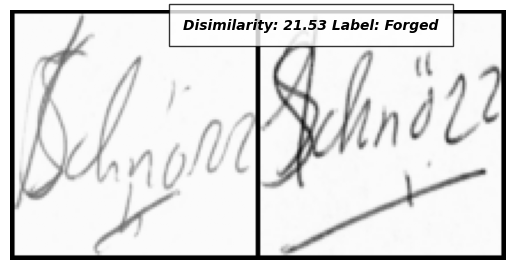

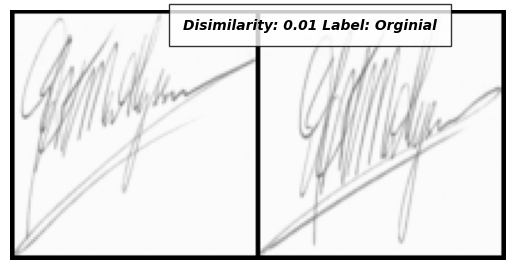

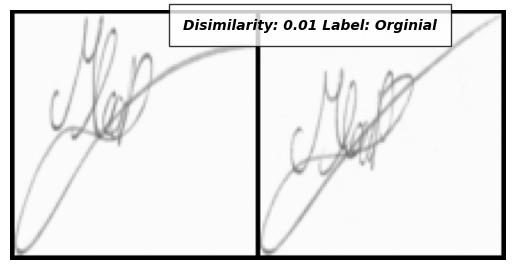

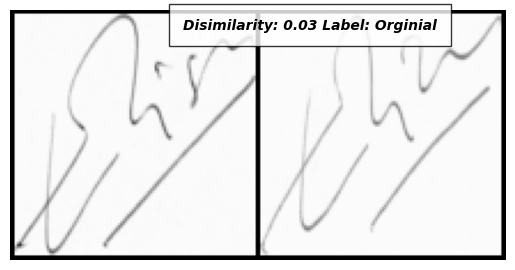

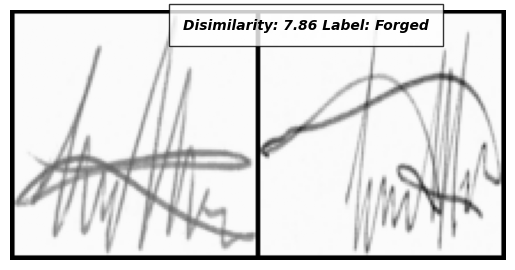

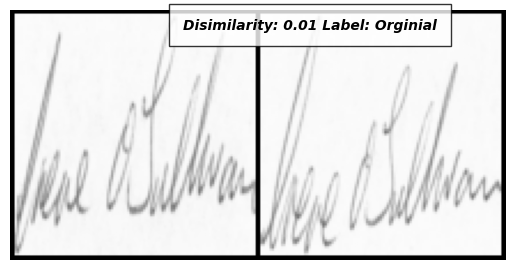

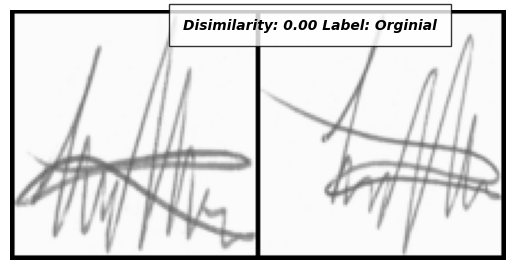

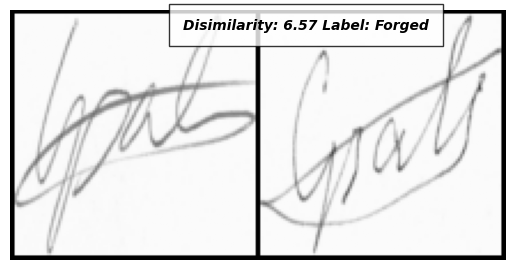

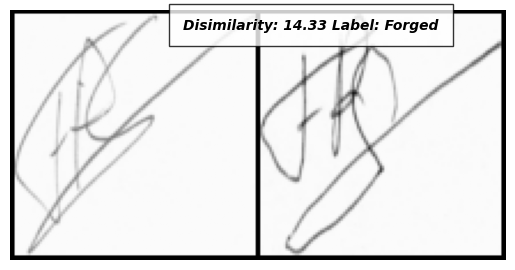

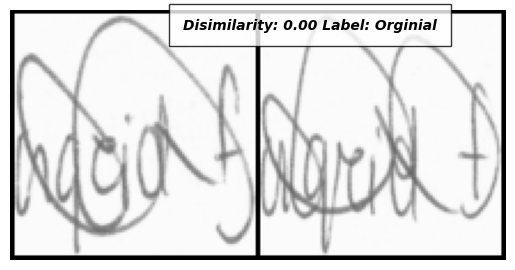

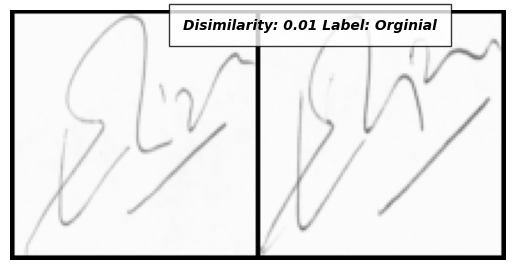

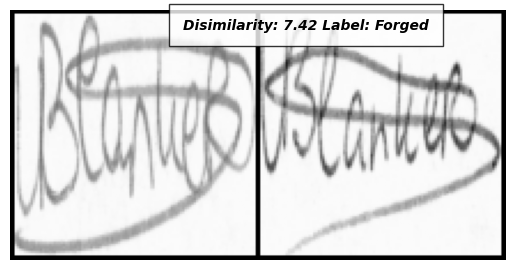

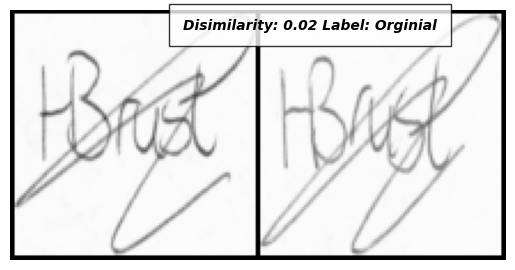

In [20]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[1]])
list_1 = torch.FloatTensor([[0]])
for i, data in enumerate(test_dataloader,0): 
    x0, x1 , label = data
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = model(x0.to(device),x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        label="Original"
    else:
        label="Forged"
    show_image(torchvision.utils.make_grid(concatenated),'Disimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
    counter=counter+1
    if counter ==20:
        break